# FFT Introduction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import write
from scipy.fft import (
    fft, 
    fftfreq,
    rfft, 
    rfftfreq,
    irfft
)
import torch

from IPython.display import (
    Audio, 
    display
)

# Wave Function

In [2]:
# SAMPLING_RATE = 44100              # Hertz
SAMPLING_RATE = 16000              # Hertz
SAMPLE_BIT_DEPTH: int = 16         # 16 bit sample bit depth
MAX_SIGNED_INT16: np.int16 = np.iinfo(np.int16).max
SAMPLE_MAX_AMPLITUDE: int = MAX_SIGNED_INT16

DURATION = 5  # Seconds

<img src="image/radian_to_time.jpeg" align="left" width=400/>

In [3]:
def wave(
    frequency: float = 1.,
    sampling_rate: int = SAMPLING_RATE,
    duration: float = 1.
):
    """
    Args:
        sampling_rate: how many samples to take per second
        frequency: number of cycles in a second
        duration: total length of sampling in seconds.

    Returns (x, y)
    """
    num_samples: int = sampling_rate * duration
    x = np.linspace(
        start=0, 
        stop=duration, 
        num=num_samples, 
        endpoint=False    # DO NOT include stop as a sample point (need exactly SAMPLING_RATE points / sec)
    ).astype(np.float64)
    y = np.sin(frequency * 2.0 * np.pi * x).astype(np.float64)

    return x, y

# Synthetic sound with white noise

1. Create a wave of Guitar 3rd string note (A2) which has the frequency 110 Hz. Added a noise of 2000 Hz.
2. Quantize the wave to 16 bit depth.

In [4]:
t, base = wave(frequency=110, sampling_rate=SAMPLING_RATE, duration=DURATION)
_, noise = wave(frequency=1000, sampling_rate=SAMPLING_RATE, duration=DURATION)
noise *= 0.2
base.shape

(80000,)

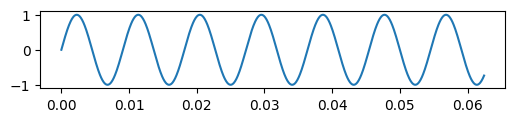

In [5]:
plt.figure(figsize=(6, 1))
plt.plot(t[:1000], base[:1000])
plt.show()

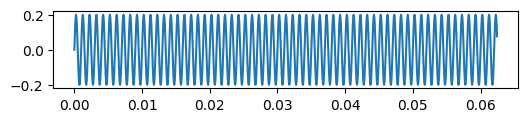

In [6]:
plt.figure(figsize=(6, 1))
plt.plot(t[:1000], noise[:1000])
plt.show()

## Quantize to 16 bit signed

In [7]:
synthesized = base + noise
quantized = np.int16(synthesized * SAMPLE_MAX_AMPLITUDE / synthesized.max()) 

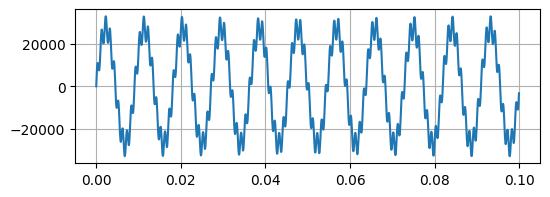

In [8]:
num_samples: int = int(len(t) / 50)  # .1 second

plt.figure(figsize=(6, 2))
plt.grid()
plt.plot(t[:num_samples], quantized[:num_samples])

## Save to a wav file

Save the wave data as 16 bit wav format. Compare the generated sound wave with the [A2 sound](https://www.youtube.com/watch?v=JNlH0M2ujS8).

In [9]:
write("a5_noise.wav", SAMPLING_RATE, quantized)

In [10]:
display(Audio("a5_noise.wav"))

# FFT

* [scipy.fft](https://docs.scipy.org/doc/scipy/tutorial/fft.html) yields Fourier Coefficients as complex numbers.
* [fftfreq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html#scipy.fft.fftfreq) calculates the frequencies in the center of each bin in the output of fft().

```yf = np.abs(fft(quantized))``` because FFT  ```ABS(c)``` computes $\sqrt{a^2 + b^2}$ for a complex number ```c = a + bi``` , which is an overall amplitude as a single value. 

<img src="image/fourier_complex_form.png" align="left" width=300/>

The FFT diagrams shows the two frequencies, one for the A2 note and the other is noise. The maximum frequency captured is the Nyquist frequency, which is exactly half of the **SAMPLING_RATE**.

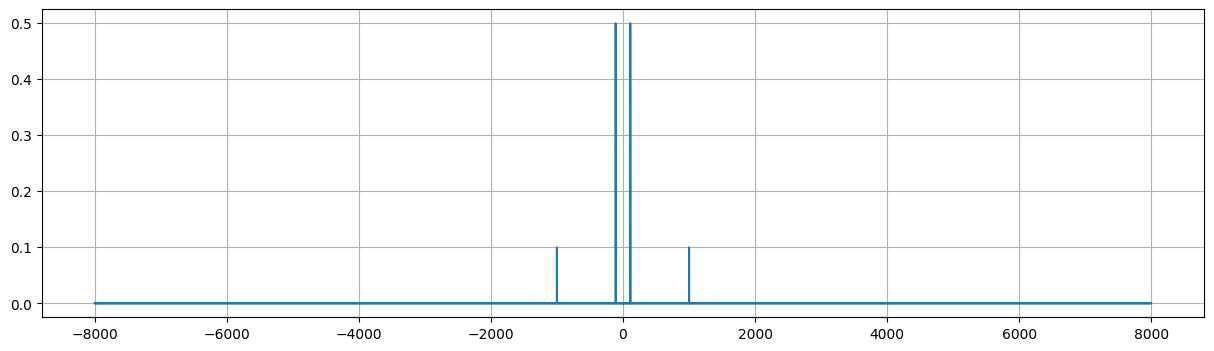

In [19]:
N_SAMPLES = SAMPLING_RATE * DURATION

yf = np.abs(fft(synthesized)) / N_SAMPLES
xf = fftfreq(
    n=N_SAMPLES,             # window length
    d=(1 / SAMPLING_RATE)    # delta(t) = sample spacing.
)

plt.figure(figsize=(15, 4))
plt.grid()
plt.plot(xf, yf)
plt.ticklabel_format(scilimits=(-99, 99))
plt.show()

The negative-positive symmetry is a side effect of putting real-valued input into the Fourier transform.  [rfft()](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html) exploits this symmetry to make Fourier transform faster by computing only half of it. Hence, up to twice as fast as fft(), but some input lengths are faster than others.

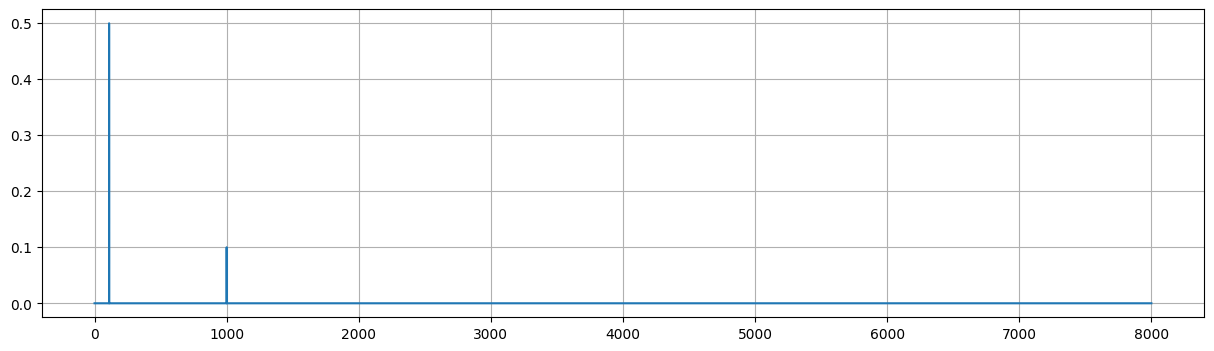

In [16]:
yf = np.abs(rfft(synthesized)) / N_SAMPLES
xf = rfftfreq(
    n=N_SAMPLES,             # window length
    d=(1 / SAMPLING_RATE)    # delta(t) = sample spacing.
)

plt.figure(figsize=(15, 4))
plt.grid()
plt.plot(xf, yf)
plt.ticklabel_format(scilimits=(-99, 99))
plt.show()

# Revert to wave

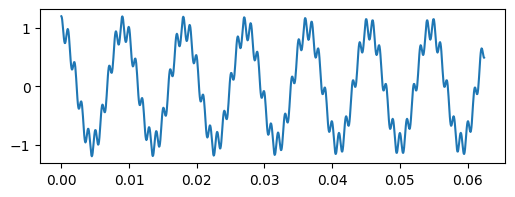

In [17]:
reverted = irfft(yf) * N_SAMPLES
plt.figure(figsize=(6, 2))
plt.plot(t[:1000], reverted[:1000])
plt.show()